## FakeNewsNet (Exploratory Data Analysis)

### Imports

In [1]:
# python imports
import os
import zipfile
import json
import re

from collections import Counter

# external library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType
from pyspark.sql import DataFrame
from pyspark.rdd import RDD

from wordcloud import WordCloud, STOPWORDS
from efficient_apriori import apriori
from plotnine import *

### Datasets

In [2]:
# ----------------------------------------
# download and unzip dataset if missing
# ----------------------------------------
def get_or_download_dataset():
    path_dataset       = "./dataset"
    path_group_by_user = "./dataset/group_by_user"
    path_unique_users  = "./dataset/unique_users"
    if not os.path.exists(path_dataset):
        print("creating directories here...")
        !pwd
        os.mkdir(path_dataset)
        os.mkdir(path_group_by_user)
        os.mkdir(path_unique_users)
        print("downloading dataset...")
        # https://medium.com/@acpanjan/download-google-drive-files-using-wget-3c2c025a8b99
        file_link_1 = 'https://drive.google.com/file/d/1UBFC0m5F4sln-YSP3zkq-5__ZJVzycme/view?usp=sharing'
        file_link_2 = 'https://drive.google.com/file/d/1gXmSAoH-gT7fAcq0g16tnb-fx1hTDv5M/view?usp=sharing'
        file_link_3 = 'https://drive.google.com/file/d/1KpTogf6HIgicXDjrEANjAO4Bg-5zQ2Iq/view?usp=sharing'
        file_link_4 = 'https://drive.google.com/file/d/1C09l3Mq7SrzJ1hYFK6Y2kbRbZsmko3Ew/view?usp=sharing'
        file_id_1   = '1UBFC0m5F4sln-YSP3zkq-5__ZJVzycme'
        file_id_2   = '1gXmSAoH-gT7fAcq0g16tnb-fx1hTDv5M'
        file_id_3   = '1KpTogf6HIgicXDjrEANjAO4Bg-5zQ2Iq'
        file_id_4   = '1C09l3Mq7SrzJ1hYFK6Y2kbRbZsmko3Ew'
        file_name_1 = 'gossipcop.zip'
        file_name_2 = 'politifact.zip'
        file_name_3 = 'gc_all.csv'
        file_name_4 = 'pf_all.csv'
        !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1UBFC0m5F4sln-YSP3zkq-5__ZJVzycme' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1UBFC0m5F4sln-YSP3zkq-5__ZJVzycme" -O gossipcop.zip  && rm -rf /tmp/cookies.txt
        !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1gXmSAoH-gT7fAcq0g16tnb-fx1hTDv5M' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1gXmSAoH-gT7fAcq0g16tnb-fx1hTDv5M" -O politifact.zip && rm -rf /tmp/cookies.txt
        !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1KpTogf6HIgicXDjrEANjAO4Bg-5zQ2Iq' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1KpTogf6HIgicXDjrEANjAO4Bg-5zQ2Iq" -O gc_all.csv     && rm -rf /tmp/cookies.txt
        !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1C09l3Mq7SrzJ1hYFK6Y2kbRbZsmko3Ew' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1C09l3Mq7SrzJ1hYFK6Y2kbRbZsmko3Ew" -O pf_all.csv     && rm -rf /tmp/cookies.txt
        !ls -l
        print("extracting dataset...")
        with zipfile.ZipFile(file_name_1, 'r') as zip_ref:
            zip_ref.extractall(path_group_by_user)
            !rm 'gossipcop.zip'
        with zipfile.ZipFile(file_name_2, 'r') as zip_ref:
            zip_ref.extractall(path_group_by_user)
            !rm 'politifact.zip'
        !mv gc_all.csv ./dataset/unique_users
        !mv pf_all.csv ./dataset/unique_users
        print("dataset successfully downloaded and extracted!")
    else:
        print("dataset path exists! skipping...")
    return path_dataset
# ----------------------------------------
# call sites
# ----------------------------------------
path_dataset = get_or_download_dataset()

creating directories here...
/Users/lionel/user_github/CS5344_project
downloading dataset...
--2022-04-17 19:20:58--  https://docs.google.com/uc?export=download&confirm=t&id=1UBFC0m5F4sln-YSP3zkq-5__ZJVzycme
Resolving docs.google.com (docs.google.com)... 142.251.10.138, 142.251.10.113, 142.251.10.102, ...
Connecting to docs.google.com (docs.google.com)|142.251.10.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-2k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/i9jol8dp41o2mt78us8dvu3cpflfljcl/1650194400000/04286633698865915993/*/1UBFC0m5F4sln-YSP3zkq-5__ZJVzycme?e=download [following]
--2022-04-17 19:20:59--  https://doc-10-2k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/i9jol8dp41o2mt78us8dvu3cpflfljcl/1650194400000/04286633698865915993/*/1UBFC0m5F4sln-YSP3zkq-5__ZJVzycme?e=download
Resolving doc-10-2k-docs.googleusercontent.com (doc-10-2k-docs.googleusercontent.com)... 74.125.

### Dataframes

In [3]:
# ----------------------------------------
# convert to spark rdd from json
# ----------------------------------------
def to_rdd_spark(sqlcontext, path, head_len = None):
    if head_len is None:
        print("reading " + path + "...")
        df_all = sqlcontext.read.json(path + "/union/*.json")
        return df_all
    directories = os.listdir(path)
    json_files = []
    df_all = spark.createDataFrame([], StructType([]))
    print("reading first " + str(head_len) + " json files in " + str(len(directories)) + " directories in " + path + "...")
    for index,directory in enumerate(directories):
        path_prefix = path + "/" + directory + "/tweets"
        files = os.listdir(path_prefix)
        for file in files:
            json_files.append(path_prefix + "/" + file)
        if head_len is not None and len(json_files) >= head_len:
            break
    if head_len is not None:
        df_all = sqlcontext.read.json(json_files[:head_len])
        assert len(json_files[:head_len]) == df_all.count()
    else:
        df_all = sqlcontext.read.json(json_files)
    return df_all
# ----------------------------------------
# call sites
# ----------------------------------------
sparksession = SparkSession.builder.appName('FakeNewsNet').getOrCreate()
sparkcontext = sparksession.sparkContext
sqlcontext   = SQLContext(sparkcontext)

print("reading RDDs...")
dd_fake_1 = to_rdd_spark(sqlcontext, path_dataset + "/group_by_user" + "/gossipcop"  + "/fake")
dd_real_1 = to_rdd_spark(sqlcontext, path_dataset + "/group_by_user" + "/gossipcop"  + "/real")
dd_fake_2 = to_rdd_spark(sqlcontext, path_dataset + "/group_by_user" + "/politifact" + "/fake")
dd_real_2 = to_rdd_spark(sqlcontext, path_dataset + "/group_by_user" + "/politifact" + "/real")

print("reading Dataframes...")
df_fake_1 = dd_fake_1.toPandas()
df_real_1 = dd_real_1.toPandas()
df_fake_2 = dd_fake_2.toPandas()
df_real_2 = dd_real_2.toPandas()

print("reading CSVs...")
df_uniq_1 = pd.read_csv("./dataset/unique_users/gc_all.csv")
df_uniq_2 = pd.read_csv("./dataset/unique_users/pf_all.csv")

print("reading done!")

22/04/17 19:21:30 WARN Utils: Your hostname, Lionels-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.188 instead (on interface en0)
22/04/17 19:21:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/17 19:21:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/usr/local/Caskroom/miniconda/base/envs/bdat/lib/python3.10/site-packages/pyspark/sql/context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.


reading RDDs...
reading ./dataset/group_by_user/gossipcop/fake...


reading ./dataset/group_by_user/gossipcop/real...


reading ./dataset/group_by_user/politifact/fake...
reading ./dataset/group_by_user/politifact/real...


reading Dataframes...


reading CSVs...
reading done!


/var/folders/50/m5lnz9q53y51xvwvxtbn4yf00000gn/T/ipykernel_40016/1001854463.py:47: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.


### Print Datasets

In [4]:
# ----------------------------------------
# print raw data
# ----------------------------------------
def print_dataset(dataset):
    for data in dataset:
        if isinstance(data, RDD):
            myRDD.take(20).foreach(println)
        if isinstance(data, DataFrame):
            print("(" + str(data.count()) + "," + str(len(data.columns)) + ")")
            print(data.columns)
            print(data.summary().show())
        if isinstance(data, pd.DataFrame):
            print(data.shape)
            print(data.info())
            print(data.columns)
            print(data.describe())
# ----------------------------------------
# call sites
# ----------------------------------------
print("========== RDDs ==========")
print_dataset([dd_fake_1, dd_real_1, dd_fake_2, dd_real_2])
print("========== DFs ==========")
print_dataset([df_fake_1, df_real_1, df_fake_2, df_real_2])
print("========== CSVs ==========")
print_dataset([df_uniq_1, df_uniq_2])

========== RDDs ==========


(195615,17)
['avg_favorite_count', 'avg_retweet_count', 'created_at', 'favourites_count', 'follower_count', 'friends_count', 'is_fact', 'list_of_tweets', 'num_of_tweets', 'retweeted_tweets_count', 'screen_name', 'source', 'statuses_count', 'total_favorite_count', 'total_retweet_count', 'user_id', 'verified']


+-------+------------------+------------------+--------------------+------------------+-----------------+-----------------+-------+------------------+----------------------+--------------------+---------+-----------------+--------------------+-------------------+--------------------+
|summary|avg_favorite_count| avg_retweet_count|          created_at|  favourites_count|   follower_count|    friends_count|is_fact|     num_of_tweets|retweeted_tweets_count|         screen_name|   source|   statuses_count|total_favorite_count|total_retweet_count|             user_id|
+-------+------------------+------------------+--------------------+------------------+-----------------+-----------------+-------+------------------+----------------------+--------------------+---------+-----------------+--------------------+-------------------+--------------------+
|  count|            195614|            195614|              195614|            195614|           195614|           195614| 195615|            19

(64942,17)
['avg_favorite_count', 'avg_retweet_count', 'created_at', 'favourites_count', 'follower_count', 'friends_count', 'is_fact', 'list_of_tweets', 'num_of_tweets', 'retweeted_tweets_count', 'screen_name', 'source', 'statuses_count', 'total_favorite_count', 'total_retweet_count', 'user_id', 'verified']


+-------+-------------------+------------------+--------------------+-----------------+-----------------+------------------+-------+------------------+----------------------+--------------------+---------+-----------------+--------------------+-------------------+--------------------+
|summary| avg_favorite_count| avg_retweet_count|          created_at| favourites_count|   follower_count|     friends_count|is_fact|     num_of_tweets|retweeted_tweets_count|         screen_name|   source|   statuses_count|total_favorite_count|total_retweet_count|             user_id|
+-------+-------------------+------------------+--------------------+-----------------+-----------------+------------------+-------+------------------+----------------------+--------------------+---------+-----------------+--------------------+-------------------+--------------------+
|  count|              64942|             64942|               64942|            64942|            64942|             64942|  64942|          

+-------+------------------+-----------------+--------------------+------------------+------------------+-----------------+-------+------------------+----------------------+--------------------+----------+------------------+--------------------+-------------------+--------------------+
|summary|avg_favorite_count|avg_retweet_count|          created_at|  favourites_count|    follower_count|    friends_count|is_fact|     num_of_tweets|retweeted_tweets_count|         screen_name|    source|    statuses_count|total_favorite_count|total_retweet_count|             user_id|
+-------+------------------+-----------------+--------------------+------------------+------------------+-----------------+-------+------------------+----------------------+--------------------+----------+------------------+--------------------+-------------------+--------------------+
|  count|             68995|            68995|               68995|             68995|             68995|            68995|  68996|        

+-------+------------------+-----------------+--------------------+------------------+------------------+-----------------+-------+-----------------+----------------------+-------------------+----------+------------------+--------------------+-------------------+--------------------+
|summary|avg_favorite_count|avg_retweet_count|          created_at|  favourites_count|    follower_count|    friends_count|is_fact|    num_of_tweets|retweeted_tweets_count|        screen_name|    source|    statuses_count|total_favorite_count|total_retweet_count|             user_id|
+-------+------------------+-----------------+--------------------+------------------+------------------+-----------------+-------+-----------------+----------------------+-------------------+----------+------------------+--------------------+-------------------+--------------------+
|  count|            185114|           185114|              185114|            185114|            185114|           185114| 185114|           185

       avg_favorite_count  avg_retweet_count  favourites_count  \
count        68995.000000       68995.000000      6.899500e+04   
mean             4.735803           2.093724      2.283769e+04   
std            195.363892          68.401419      5.959383e+04   
min              0.000000           0.000000      0.000000e+00   
25%              0.000000           0.000000      8.400000e+01   
50%              0.000000           0.000000      2.057000e+03   
75%              0.000000           0.000000      1.731900e+04   
max          30825.000000       11130.000000      1.565570e+06   

       follower_count  friends_count  is_fact  num_of_tweets  \
count    6.899500e+04   68995.000000  68996.0   68996.000000   
mean     1.737305e+04    2136.787535      0.0       1.637022   
std      4.874631e+05    8465.550889      0.0       4.565050   
min      0.000000e+00       0.000000      0.0       1.000000   
25%      8.300000e+01     155.000000      0.0       1.000000   
50%      4.180000e+02

### Pie Charts

========== num_of_tweets ==========


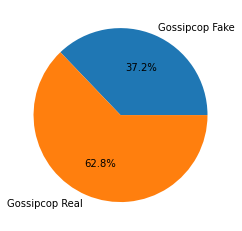

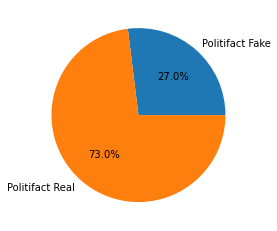

========== total_favorite_count ==========


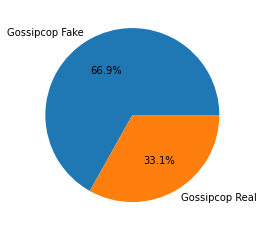

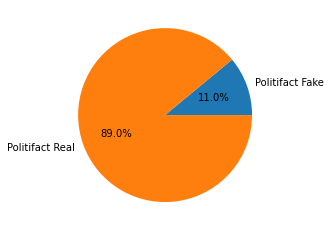

========== total_retweet_count ==========


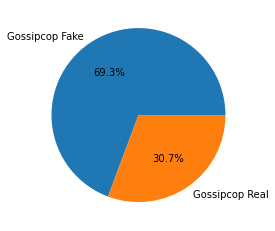

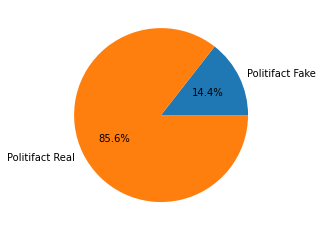

In [5]:
# ----------------------------------------
# visualize pie chart
# ----------------------------------------
def visualize_pie_chart(df_fake, df_real, column_name, labels):
    df_sum_fake = df_fake[column_name].sum()
    df_sum_real = df_real[column_name].sum()
    list_sums   = np.array([df_sum_fake, df_sum_real])
    plt.pie(list_sums, labels = labels, autopct='%1.1f%%')
    plt.show()
# ----------------------------------------
# call sites
# ----------------------------------------
print("========== num_of_tweets ==========")
visualize_pie_chart(df_fake_1, df_real_1, "num_of_tweets", ["Gossipcop Fake", "Gossipcop Real"])
visualize_pie_chart(df_fake_2, df_real_2, "num_of_tweets", ["Politifact Fake", "Politifact Real"])

print("========== total_favorite_count ==========")
visualize_pie_chart(df_fake_1, df_real_1, "total_favorite_count", ["Gossipcop Fake", "Gossipcop Real"])
visualize_pie_chart(df_fake_2, df_real_2, "total_favorite_count", ["Politifact Fake", "Politifact Real"])

print("========== total_retweet_count ==========")
visualize_pie_chart(df_fake_1, df_real_1, "total_retweet_count", ["Gossipcop Fake", "Gossipcop Real"])
visualize_pie_chart(df_fake_2, df_real_2, "total_retweet_count", ["Politifact Fake", "Politifact Real"])

### Histogram Bins of Follower Count

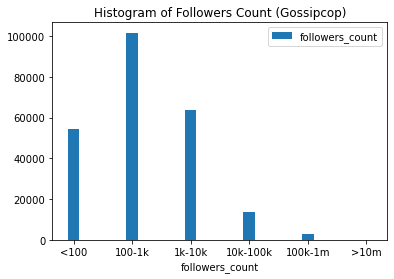

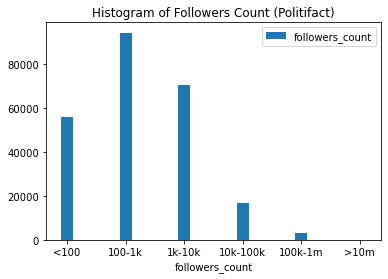

In [6]:
# ----------------------------------------
# visualize histogram bin
# ----------------------------------------
def visualize_histogram_bin(df_uniq, column_name, title):
    bin_values = [100, 1000, 10000, 100000, 1000000, 1000000]
    bin_names  = ["<100", "100-1k", "1k-10k", "10k-100k", "100k-1m", ">10m"]
    x_values   = np.arange(len(bin_names))
    y_values   = []
    
    df_notna = df_uniq[df_uniq[column_name].notna()]
    df_first = df_notna[df_notna[column_name] < bin_values[0]]
    y_values.append(len(df_first))
    for index in range(1, len(bin_values)):
        df_current = df_notna[(df_notna[column_name] >= bin_values[index - 1]) & (df_notna[column_name] < bin_values[index])]
        y_values.append(len(df_current))

    plt.bar(x_values, y_values, 0.2, label=column_name)
    plt.xticks(x_values, bin_names)
    plt.xlabel(column_name)
    plt.title(title)
    plt.legend()
    plt.show()
# ----------------------------------------
# call sites
# ----------------------------------------
visualize_histogram_bin(df_uniq_1, "followers_count", "Histogram of Followers Count (Gossipcop)")
visualize_histogram_bin(df_uniq_2, "followers_count", "Histogram of Followers Count (Politifact)")

### Favorites vs Retweets Charts

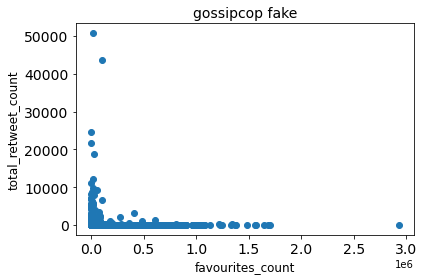

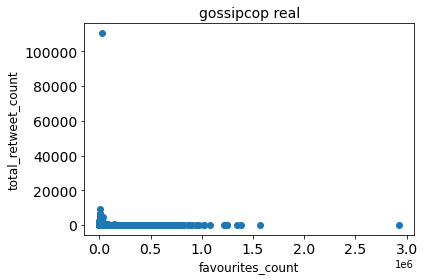

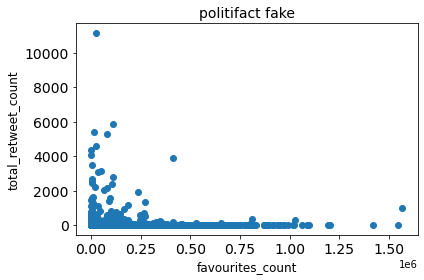

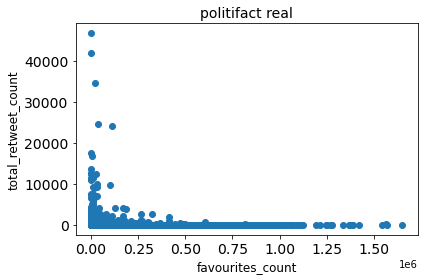

In [7]:
# ----------------------------------------
# Favorites vs Retweets
# ----------------------------------------
def favorite_vs_retweet(df, title):
    X_val = df['favourites_count']
    Y_val = df['total_retweet_count']
    plt.figure()
    plt.tick_params(labelsize=14)
    plt.scatter(X_val, Y_val)
    plt.title(title, fontsize=14)
    plt.xlabel('favourites_count', fontsize=12)
    plt.ylabel('total_retweet_count', fontsize=12)
    plt.tight_layout()
    plt.show()
# ----------------------------------------
# call sites
# ----------------------------------------
favorite_vs_retweet(df_fake_1, "gossipcop fake")
favorite_vs_retweet(df_real_1, "gossipcop real")
favorite_vs_retweet(df_fake_2, "politifact fake")
favorite_vs_retweet(df_real_2, "politifact real")

### Retweets Fake vs Real Charts

In [8]:
# ----------------------------------------
# Retweets Fake vs Real Chart
# ----------------------------------------
def retweets_fake_vs_real(rdd_fake, rdd_real, ceiling = None):
    df_retweet_fake = rdd_fake.groupBy("user_id").sum("total_retweet_count").toPandas()
    df_retweet_real = rdd_real.groupBy("user_id").sum("total_retweet_count").toPandas()
    if(ceiling is not None):
        df_retweet_fake = df_retweet_fake.drop(df_retweet_fake[df_retweet_fake["sum(total_retweet_count)"] > ceiling].index)
        df_retweet_real = df_retweet_real.drop(df_retweet_real[df_retweet_real["sum(total_retweet_count)"] > ceiling].index)
    df_fake_vs_real = pd.merge(df_retweet_fake, df_retweet_real, on='user_id', how='outer')
    df_fake_vs_real['total_retweets'] = (df_fake_vs_real['sum(total_retweet_count)_x'].fillna(0) + df_fake_vs_real['sum(total_retweet_count)_y'].fillna(0))
    return df_fake_vs_real
# ----------------------------------------
# call sites
# ----------------------------------------
# must call in separate cells for chart to render

========== Gossipcop ==========


/usr/local/Caskroom/miniconda/base/envs/bdat/lib/python3.10/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 225287 rows containing missing values.


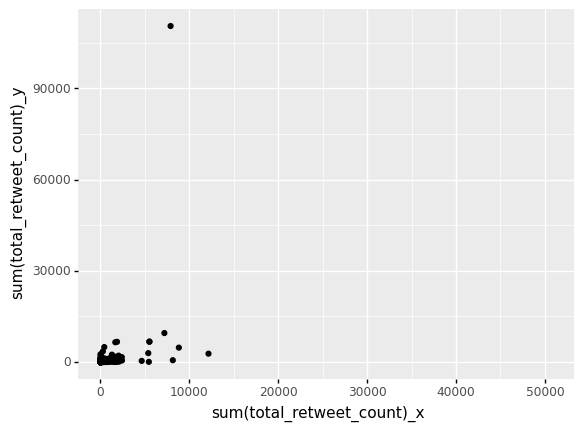

<ggplot: (416176378)>

In [9]:
print("========== Gossipcop ==========")
df_fake_vs_real_gc = retweets_fake_vs_real(dd_fake_1, dd_real_1)
p = ggplot(aes(x='sum(total_retweet_count)_x', y='sum(total_retweet_count)_y'), df_fake_vs_real_gc)
p + geom_point()

========== Gossipcop Zoom In ==========


/usr/local/Caskroom/miniconda/base/envs/bdat/lib/python3.10/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 224466 rows containing missing values.


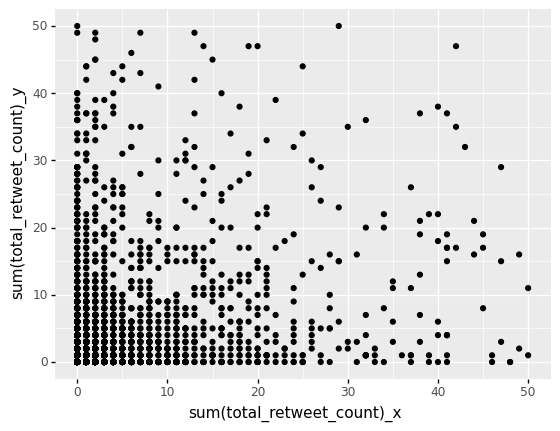

<ggplot: (415642000)>

In [10]:
print("========== Gossipcop Zoom In ==========")
df_fake_vs_real_gc_zoom = retweets_fake_vs_real(dd_fake_1, dd_real_1, 50)
p = ggplot(aes(x='sum(total_retweet_count)_x', y='sum(total_retweet_count)_y'), df_fake_vs_real_gc_zoom)
p + geom_point()

========== Politifact ==========


/usr/local/Caskroom/miniconda/base/envs/bdat/lib/python3.10/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 229956 rows containing missing values.


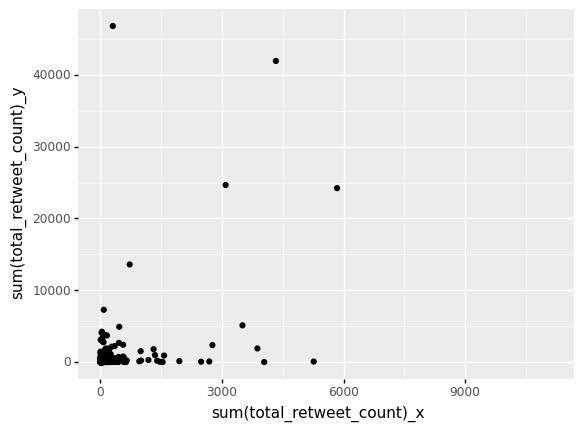

<ggplot: (415578782)>

In [11]:
print("========== Politifact ==========")
df_fake_vs_real_pf = retweets_fake_vs_real(dd_fake_2, dd_real_2)
p = ggplot(aes(x='sum(total_retweet_count)_x', y='sum(total_retweet_count)_y'), df_fake_vs_real_pf)
p + geom_point()

========== Politifact Zoom In ==========


/usr/local/Caskroom/miniconda/base/envs/bdat/lib/python3.10/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 228400 rows containing missing values.


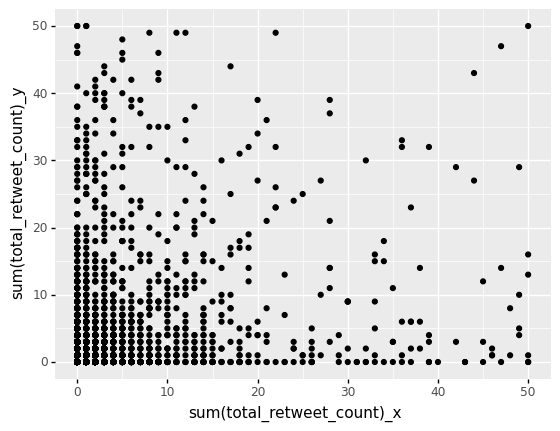

<ggplot: (415946176)>

In [12]:
print("========== Politifact Zoom In ==========")
df_fake_vs_real_pf_zoom = retweets_fake_vs_real(dd_fake_2, dd_real_2, 50)
p = ggplot(aes(x='sum(total_retweet_count)_x', y='sum(total_retweet_count)_y'), df_fake_vs_real_pf_zoom)
p + geom_point()

### Retweets Fake vs Real Histograms

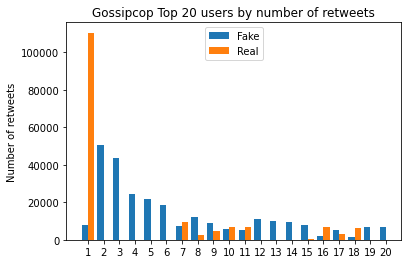

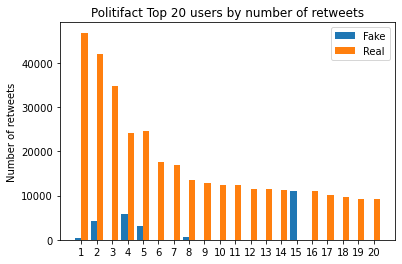

In [13]:
# ----------------------------------------
# visualize top retweeters distribution
# ----------------------------------------
def visualize_retweeters_topk(df_fake_real, dataset_name, topk):
    df_topk   = df_fake_real.sort_values("total_retweets", ascending = False)
    df_topk   = df_topk.head(topk)
    bin_names = np.arange(1, topk + 1)
    x_values  = np.arange(len(bin_names))
    topk_fake = df_topk["sum(total_retweet_count)_x"]
    topk_real = df_topk["sum(total_retweet_count)_y"]

    plt.bar(x_values - 0.2, topk_fake, 0.4, label = 'Fake')
    plt.bar(x_values + 0.2, topk_real, 0.4, label = 'Real')
    plt.xticks(x_values, bin_names)
    plt.ylabel("Number of retweets")
    plt.title(dataset_name + " Top " + str(topk) + " users by number of retweets")
    plt.legend()
    plt.show()
# ----------------------------------------
# call sites
# ----------------------------------------
visualize_retweeters_topk(df_fake_vs_real_gc, "Gossipcop", 20)
visualize_retweeters_topk(df_fake_vs_real_pf, "Politifact", 20)

### Tweet Word Counter

In [14]:
# ----------------------------------------
# count frequency of words in tweets
# ----------------------------------------
def tweet_word_counter(df, sample_percent):
    col_value = df['list_of_tweets']
    row_count = len(col_value)
    word_freq = Counter([])
    tweet_tokenlist = []
    complete_percent = 0
    for index, tweets in enumerate(col_value):
        for curr_tweet in tweets:
            curr_tweet_text = re.search(r"^.*?,\"text\":\"(.*)\",\"truncated\".*$", curr_tweet).group(1)
            words = curr_tweet_text.split()
            words = [word.lower() for word in words]
            word_freq = word_freq + Counter(words)
            if False:
                tweet_tokenlist.append(tuple(set(word_freq)))
        if index % 100 == 0:
            complete_percent += round((index / row_count) * 100, 2)
            print(str(complete_percent) + "% of dataset")
            if sample_percent is not None and complete_percent > sample_percent:
                break
    return word_freq, tweet_tokenlist
# ----------------------------------------
# call sites
# ----------------------------------------
print("processing Gossipcop Fake...")
counter_fake_1, tokenlist_fake_1 = tweet_word_counter(df_fake_1, 5)
print("processing Gossipcop Real...")
counter_real_1, tokenlist_real_1 = tweet_word_counter(df_real_1, 5)
print("processing Politifact Fake...")
counter_fake_2, tokenlist_fake_2 = tweet_word_counter(df_fake_2, 5)
print("processing Politifact Real...")
counter_real_2, tokenlist_real_2 = tweet_word_counter(df_real_2, 5)
print("processing done!")

processing Gossipcop Fake...
0.0% of dataset
0.05% of dataset
0.15000000000000002% of dataset
0.30000000000000004% of dataset
0.5% of dataset
0.76% of dataset
1.07% of dataset
1.4300000000000002% of dataset
1.84% of dataset
2.3000000000000003% of dataset
2.8100000000000005% of dataset
3.3700000000000006% of dataset
3.9800000000000004% of dataset
4.640000000000001% of dataset
5.36% of dataset
processing Gossipcop Real...
0.0% of dataset
0.15% of dataset
0.45999999999999996% of dataset
0.9199999999999999% of dataset
1.54% of dataset
2.31% of dataset
3.23% of dataset
4.3100000000000005% of dataset
5.540000000000001% of dataset
processing Politifact Fake...
0.0% of dataset
0.14% of dataset
0.43% of dataset
0.86% of dataset
1.44% of dataset
2.16% of dataset
3.0300000000000002% of dataset
4.04% of dataset
5.2% of dataset
processing Politifact Real...
0.0% of dataset
0.05% of dataset
0.16% of dataset
0.32% of dataset
0.54% of dataset
0.81% of dataset
1.1300000000000001% of dataset
1.510000000

### Stopwords

In [15]:
# ----------------------------------------
# additional stopwords to remove
# ----------------------------------------
additional_stopwords = {
    'to', 'a', 'the', 'and', 'on', '-', 'is', 'with',
    'i', 'of', 'you', '&amp;', 'for', 'out', 'air',
    'win', 'in', 'her', 'tv', 'at', 'after', 'best',
    'your', 'first', 'new', 'about', 'found', 'as',
    'how', 'via', 'my', 'by', 'if', 'one', 'four',
    'that', 'have', 'was', 'this', 'are', 'be', 'it',
    'has', 'from', 'all', 'but', 'just', 'not', 'u.s.',
    'only', 'two', 'more', 'will', 'an', 'me', 'had',
    'like', 'we', 'so', 'been', 'our', 'or', 'three',
    "i'm", 'years', 'see', 'top', '#eonline', '2018',
    'says', 'us', 'https', 'news', 't', 'co', 's',
    'https://t.co/g79yrlmstd', 'https://t.co/pas8l48opb'
    }
def filter_stopwords(counter, stopwords):

    for stopword in stopwords:
        del counter[stopword]
        del counter[stopword]
        del counter[stopword]
        del counter[stopword]
def show_top_words(counter, topk = 20):
    print("number of unqiue words: " + str(len(counter)))
    topk_words = counter.most_common(topk)
    print("most common words:")
    print(*topk_words, sep = "\n")
# ----------------------------------------
# call sites
# ----------------------------------------
stopwords  = set(STOPWORDS)
stopwords |= additional_stopwords
    
filter_stopwords(counter_fake_1, stopwords)
filter_stopwords(counter_real_1, stopwords)
filter_stopwords(counter_fake_2, stopwords)
filter_stopwords(counter_real_2, stopwords)

print("========== Gossipcop Fake ==========")
show_top_words(counter_fake_1)
print("========== Gossipcop Real ==========")
show_top_words(counter_real_1)
print("========== Politifact Fake ==========")
show_top_words(counter_fake_2)
print("========== Politifact Real ==========")
show_top_words(counter_real_2)

========== Gossipcop Fake ==========
number of unqiue words: 14110
most common words:
('love', 370)
('@youtube', 336)
('kardashian', 178)
('justin', 171)
('people', 168)
('manchester', 167)
('jennifer', 166)
('ariana', 156)
('kim', 146)
('brad', 144)
('family', 143)
('jenner', 142)
('story:', 141)
('selena', 137)
('manchester)', 136)
('connecting', 134)
('grande', 125)
('nicole', 118)
('(one', 118)
('angelina', 116)
========== Gossipcop Real ==========
number of unqiue words: 17422
most common words:
('season', 303)
('star', 213)
('dead', 168)
('awards', 154)
('wedding', 134)
('prince', 123)
('time', 122)
('meghan', 117)
('2017', 113)
('baby', 112)
('sexual', 103)
('kardashian', 102)
('list', 99)
('2', 98)
('harry', 96)
('complete', 93)
('music', 93)
('stars', 91)
('know', 90)
('pregnant', 90)
========== Politifact Fake ==========
number of unqiue words: 5111
most common words:
('trump', 117)
('house', 111)
('fake', 99)
('obama', 78)
('federal', 71)
('vaccines', 63)
('breaking:', 62)
(

### Word Clouds

========== Gossipcop Fake ==========


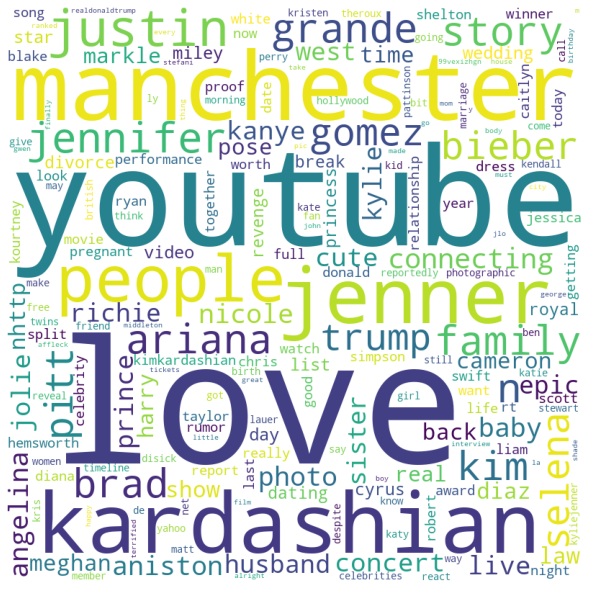

========== Gossipcop Real ==========


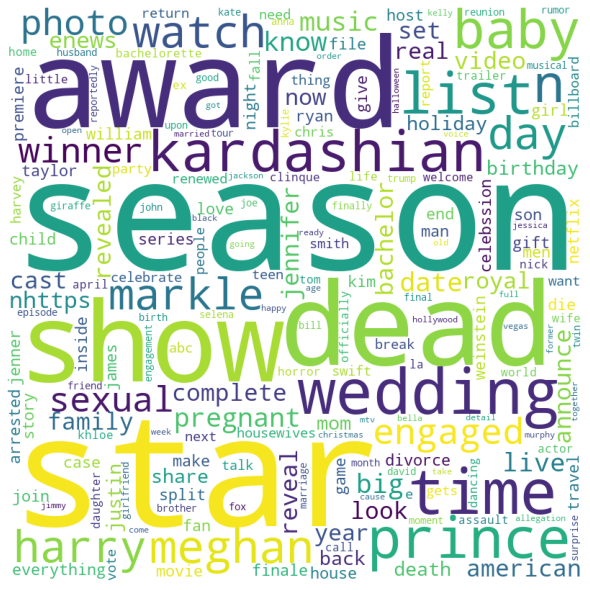

========== Politifact Fake ==========


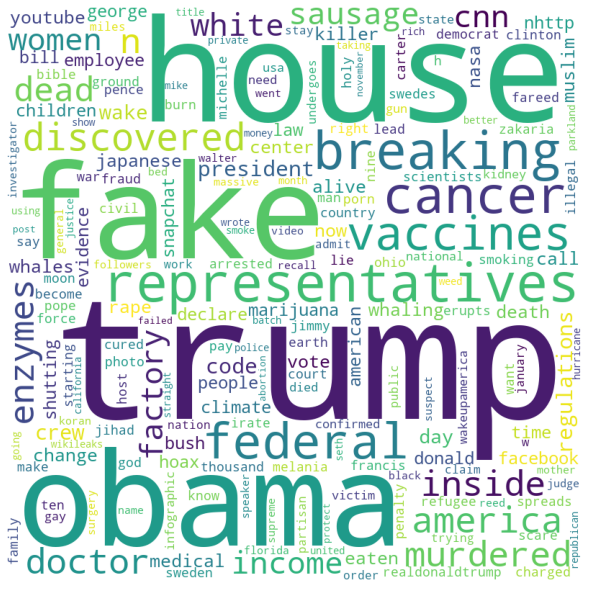

========== Politifact Real ==========


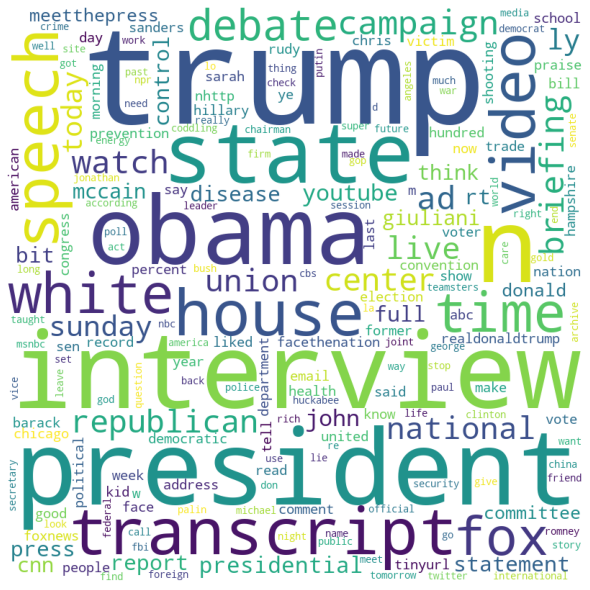

In [16]:
# ----------------------------------------
# visualize using word cloud
# ----------------------------------------
def visualize_word_cloud(counter, stopwords):
    words = " ".join(counter.elements())
    wordcloud = WordCloud(
        width = 800, height = 800, background_color ='white',
        collocations = False, stopwords = stopwords,
        min_font_size = 10).generate(words)
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()
# ----------------------------------------
# call sites
# ----------------------------------------
print("========== Gossipcop Fake ==========")
visualize_word_cloud(counter_fake_1, stopwords)
print("========== Gossipcop Real ==========")
visualize_word_cloud(counter_real_1, stopwords)
print("========== Politifact Fake ==========")
visualize_word_cloud(counter_fake_2, stopwords)
print("========== Politifact Real ==========")
visualize_word_cloud(counter_real_2, stopwords)

### Association Rules with Top Keywords

In [17]:
# ----------------------------------------
# Skipped - takes too long
# ----------------------------------------
# itemsets, rules = apriori(tokenlist_fake_1, min_support=0.9, min_confidence=0.9)
# itemsets, rules = apriori(tokenlist_real_1, min_support=0.9, min_confidence=0.9)
# itemsets, rules = apriori(tokenlist_fake_2, min_support=0.9, min_confidence=0.9)
# itemsets, rules = apriori(tokenlist_real_2, min_support=0.9, min_confidence=0.9)